In [1]:
import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of available GPUs:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. PyTorch will use the CPU.")

CUDA is available. PyTorch can use the GPU.
Number of available GPUs: 1
Current GPU device: 0
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import torch

# Before starting the training loop
torch.cuda.empty_cache()

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
import os
import cv2
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [4]:
dataset_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data"
train_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data/Training"
test_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data/Testing"
image_size = (299,299)
num_classes = 5
train_paths = glob(f"{train_path}/*/*.jpg")
test_paths = glob(f"{test_path}/*/*.jpg")

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [7]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5, random_state=ord("H"))

In [8]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [37]:
import torch
import torch.nn as nn
from torchvision import models

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the custom model class
class CustomInceptionV3(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomInceptionV3, self).__init__()
        # Load the pretrained InceptionV3 model with aux_logits set to False
        self.inception = models.inception_v3(pretrained=True)
        self.inception.aux_logits = False
        
        # Freeze all layers initially
        for param in self.inception.parameters():
            param.requires_grad = False
        
        # Unfreeze the last two layers
        for param in list(self.inception.parameters())[-2:]:
            param.requires_grad = True
        
        # Add custom convolutional layers
        self.custom_conv1 = nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1)
        self.custom_bn1 = nn.BatchNorm2d(256)
        self.custom_conv2 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.custom_bn2 = nn.BatchNorm2d(128)
        
        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Modify the final fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128 * 1 * 1, 10),
            nn.ReLU(),
            nn.Linear(10, num_classes)
        )
        
    def forward(self, x):
        # Pass through InceptionV3 layers until the final convolutional layer
        x = self.inception.Conv2d_1a_3x3(x)
        x = self.inception.Conv2d_2a_3x3(x)
        x = self.inception.Conv2d_2b_3x3(x)
        x = self.inception.maxpool1(x)
        x = self.inception.Conv2d_3b_1x1(x)
        x = self.inception.Conv2d_4a_3x3(x)
        x = self.inception.maxpool2(x)
        x = self.inception.Mixed_5b(x)
        x = self.inception.Mixed_5c(x)
        x = self.inception.Mixed_5d(x)
        x = self.inception.Mixed_6a(x)
        x = self.inception.Mixed_6b(x)
        x = self.inception.Mixed_6c(x)
        x = self.inception.Mixed_6d(x)
        x = self.inception.Mixed_6e(x)
        x = self.inception.Mixed_7a(x)
        x = self.inception.Mixed_7b(x)
        x = self.inception.Mixed_7c(x)
        
        # Pass through custom convolutional layers
        x = self.custom_conv1(x)
        x = self.custom_bn1(x)
        x = torch.relu(x)
        x = self.custom_conv2(x)
        x = self.custom_bn2(x)
        x = torch.relu(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        
        x = torch.flatten(x, 1)
        
        # Pass through the final fully connected layers
        x = self.fc(x)
        return x

# Define number of classes
num_classes = 4

# Create an instance of the custom model
model = CustomInceptionV3(num_classes=num_classes)

# Move the model to the device (GPU or CPU)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


In [34]:
def train_epoch():
    model.train()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels_indices = images.to(device), labels_indices.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels_indices)
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels_indices.size(0)
        total_correct += (predicted == labels_indices).sum().item()
        
        loss.backward()
        optimizer.step()
        
        if (batch_number and batch_number % 150 == 0):
            c_loss = total_loss / (batch_number + 1)
            accuracy = total_correct / total_predictions
            print(f"Batch {batch_number}/{len(train_loader)}, Loss: {c_loss:0.4f}, Accuracy: {accuracy * 100:.2f}%")
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [38]:
def eval_model():
    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()
            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [39]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_score = float("inf")
n_epochs = 30
tolerance = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")

Epoch 0,   Batch 150/179, Loss: 0.6382, Accuracy: 76.90%
Train Loss: 0.5985, Train Accuracy: 78.36%
Eval Loss: 0.3840, Eval Accuracy: 86.41%
Epoch 1,   Batch 150/179, Loss: 0.3013, Accuracy: 89.09%
Train Loss: 0.2987, Train Accuracy: 89.18%
Eval Loss: 0.3938, Eval Accuracy: 84.89%
Epoch 2,   Batch 150/179, Loss: 0.2551, Accuracy: 90.50%
Train Loss: 0.2494, Train Accuracy: 90.70%
Eval Loss: 0.2704, Eval Accuracy: 89.47%
Epoch 3,   Batch 150/179, Loss: 0.2202, Accuracy: 91.66%
Train Loss: 0.2208, Train Accuracy: 91.72%
Eval Loss: 0.2646, Eval Accuracy: 90.69%
Epoch 4,   Batch 150/179, Loss: 0.2049, Accuracy: 92.53%
Train Loss: 0.2039, Train Accuracy: 92.58%
Eval Loss: 0.2447, Eval Accuracy: 91.15%
Epoch 5,   Batch 150/179, Loss: 0.1955, Accuracy: 92.76%
Train Loss: 0.1912, Train Accuracy: 92.96%
Eval Loss: 0.2340, Eval Accuracy: 90.84%
Epoch 6,   Batch 150/179, Loss: 0.1668, Accuracy: 94.00%
Train Loss: 0.1688, Train Accuracy: 94.03%
Eval Loss: 0.2529, Eval Accuracy: 89.16%
Epoch 7,   Ba

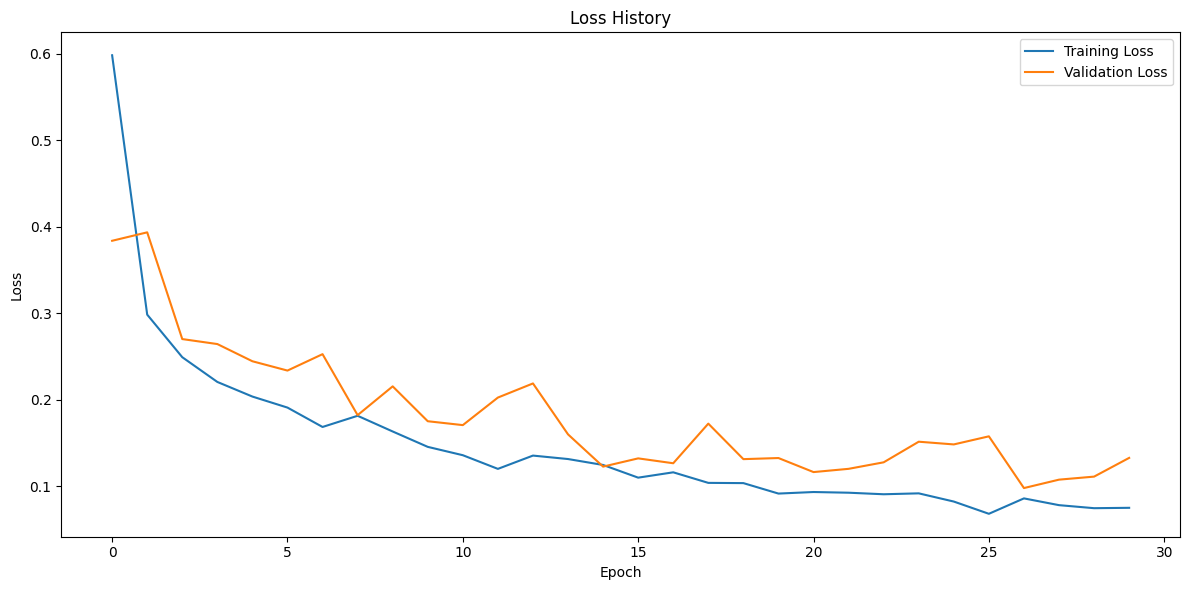

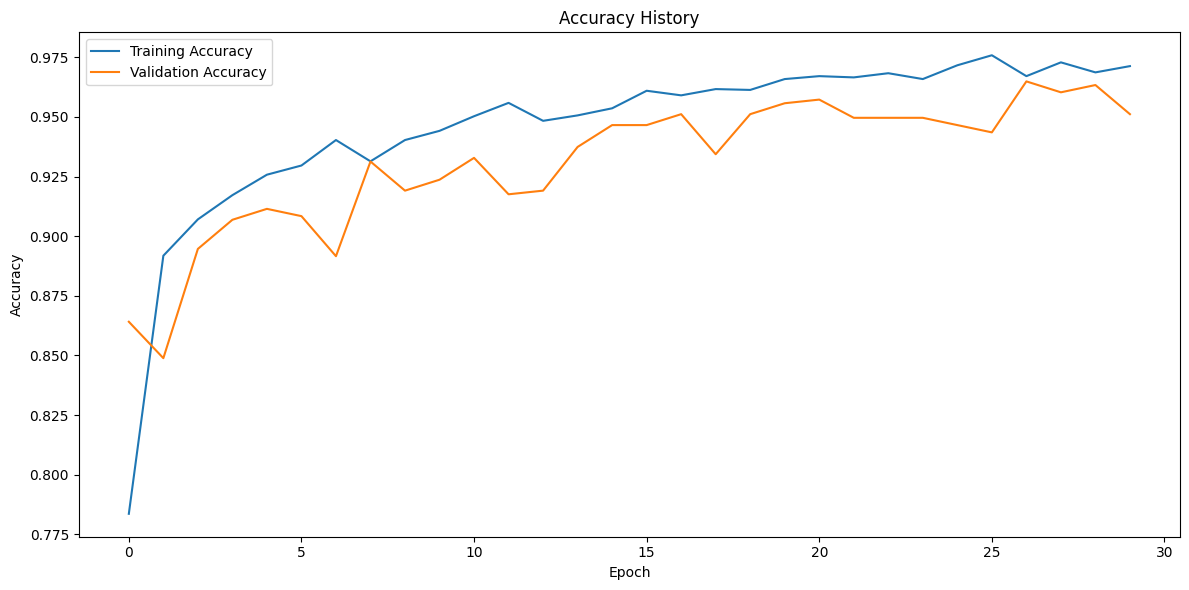

In [41]:
import matplotlib.pyplot as plt

# Plotting loss history
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')
plt.tight_layout()
plt.show()

# Plotting accuracy history
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')
plt.tight_layout()
plt.show()


In [42]:
models = glob("C:/Users/91623/Desktop/Brain_tumor_research/reseach/*")
model_num = [int(i.split("_")[-1]) for i in models if i.split("_")[-1].isdigit()]
best_model_path = "C:/Users/91623/Desktop/Brain_tumor_research/reseach/model_" + str(sorted(model_num)[-1])
best_model_path

'C:/Users/91623/Desktop/Brain_tumor_research/reseach/model_27'

In [44]:
from torchvision import models
inception = models.inception_v3(pretrained=True)
best_model =CustomInceptionV3(num_classes=4).to(device)

# Load the state dictionary from the best model path
pretrained_dict = torch.load(best_model_path, map_location=device)

# Filter out unnecessary keys
model_dict = best_model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

# Update the state dictionary
model_dict.update(pretrained_dict)

# Load the updated state dictionary into the model
best_model.load_state_dict(model_dict)

# Optional: Verify the model
print(best_model)


AttributeError: 'list' object has no attribute 'inception_v3'